In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image


In [2]:
print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")


requests        2.32.3
BeautifulSoup   4.13.3


In [3]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [4]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [5]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [6]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [7]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [8]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [9]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [10]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


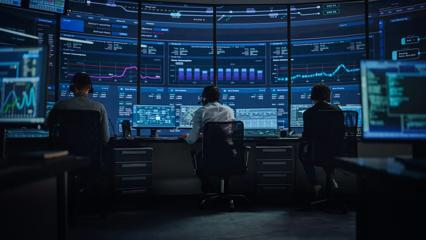

[deepfakes, AI brigading and harassment, AI flooding the zone with propaganda, TikTok to name a few](https://www.civitasinstitute.org/research/ais-challenges-to-free-speech-doctrine?ref=biztoc.com)

___

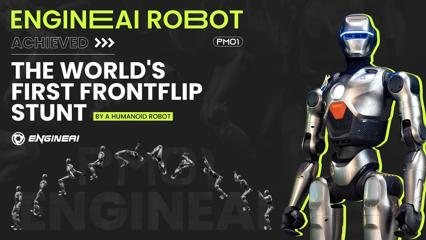

[Robot does front flip, walks less awkwardly, unlike the robots that walk like they really need to go to the bathroom](https://www.youtube.com/watch?v=N_ALMlOipCI) - YouTube

___

Apple Intelligence FTW

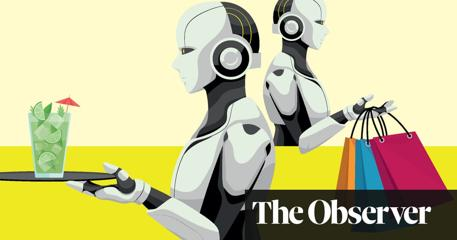

[Trying out Operator](https://www.theguardian.com/technology/2025/mar/09/who-bought-this-smoked-salmon-how-ai-agents-will-change-the-internet-and-shopping-lists) - the Guardian

___

[“I’ll hear a pause, then ‘Hmm,’ and all of a sudden, it’s the perfect answer”](https://www.cnbc.com/2025/03/09/google-ai-interview-coder-cheat.html)

___

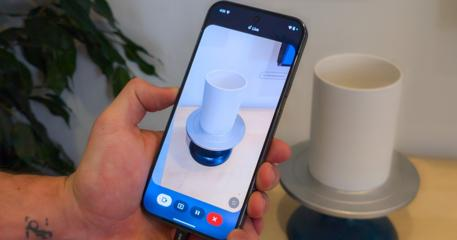

[I saw the new Gemini and Project Astra, here’s why it’s the future.](https://www.digitaltrends.com/mobile/i-saw-new-gemini-and-project-astra-heres-why-its-the-future/) - Digital Trends

___

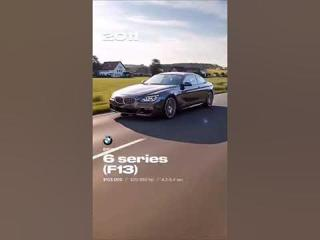

[kind of like the evolution of BMW AI video](https://www.youtube.com/watch?v=HIaZ1UpqK1c) - YouTube

___

[An AI timelapse of a lifetime www.reddit.com/r/aivideo/co...

might be a trend of people making these poignant from a series of actual old pictures](https://www.reddit.com/r/aivideo/comments/1j69c3e/she_lives_a_quiet_life/)

___

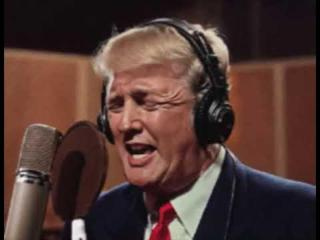

[We Are The World deepfake](https://youtu.be/j9EyhYt2TeI?si=uIOAvCqA5kw6jGVM) - YouTube

___

[How Much Are LLMs Actually Boosting Real-World Programmer Productivity? — LessWrong](https://www.lesswrong.com/posts/tqmQTezvXGFmfSe7f/how-much-are-llms-actually-boosting-real-world-programmer)

___

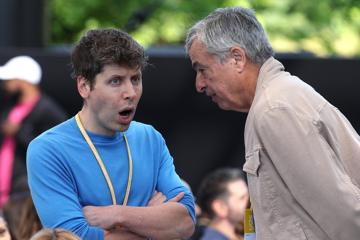

[Microsoft's Relationship With OpenAI Is Not Looking Good](https://gizmodo.com/microsofts-relationship-with-openai-is-not-looking-good-2000573293) - Gizmodo

___

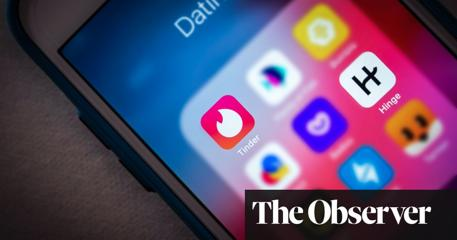

[AI ‘wingmen’ bots to write profiles and flirt on dating apps](https://www.theguardian.com/lifeandstyle/2025/mar/08/ai-wingmen-bots-to-write-profiles-and-flirt-on-dating-apps) - the Guardian

___

[How to Automate Data Analysis Using Google's Data Science Agent in Colab](https://aiagentspost.com/how-to-automate-data-analysis-using-googles-data-science-agent-in-colab/)

___

[Thousands of Cat-Eared Robots Are Waiting Tables in Japan’s Restaurants](https://www.bloomberg.com/news/features/2025-03-06/thousands-of-cat-eared-robots-are-waiting-tables-in-japan)

___

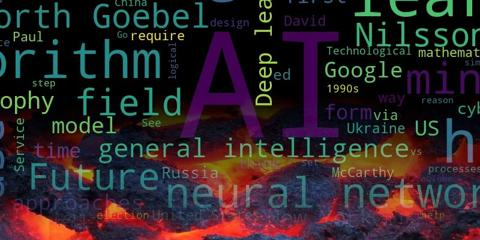

[Texas ERCOT Slammed with 99GW of New Energy Demand](https://wattsupwiththat.com/2025/03/07/the-ai-age-begins-texas-ercot-slammed-with-99gw-of-new-energy-demand/) - Watts Up With That?

___

[Outrage Over Trump Use of AI to Revoke Visas of Students Deemed 'Hamas Supporters' 

free speech, as long as they like what you are saying](https://www.commondreams.org/news/trump-ai-student-visas)

___

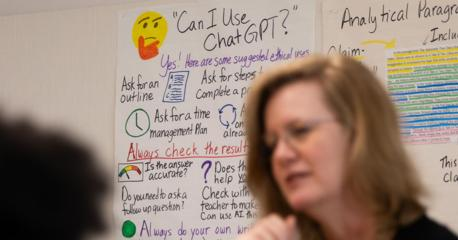

[A High School Student Explains How Educators Can Adapt to AI](https://themarkup.org/hello-world/2025/03/08/a-high-school-student-explains-how-educators-can-adapt-to-ai)

___

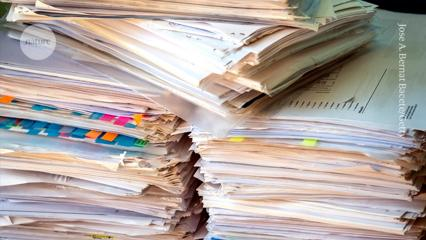

[Using AI tools to spot errors in research papers](https://www.nature.com/articles/d41586-025-00648-5)

___

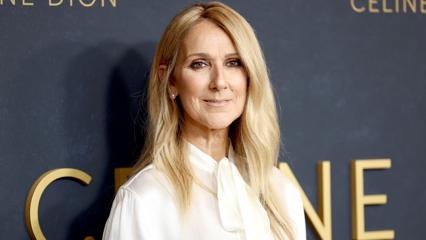

[Celine Dion Calls Out 'Fake and Not Approved' AI-Generated Music of Hers Circulating Online](https://www.thewrap.com/celine-dion-ai-voice-warning-instagram/) - TheWrap

___

[Google Is Still Behind in AI. Why?](https://www.theinformation.com/articles/google-is-still-behind-in-ai-why)

___

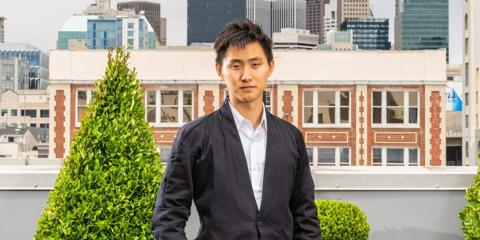

[More AI in the military. VCs love it but some are wary.](https://www.businessinsider.com/ai-agents-coming-military-new-scaleai-contract-2025-3) - Business Insider

___

[US drops some claims like bid to make Google sell AI investments like Anthropic, still wants Chrome divested.](https://www.reuters.com/technology/us-drops-bid-make-google-sell-ai-investments-antitrust-case-2025-03-07/)

___

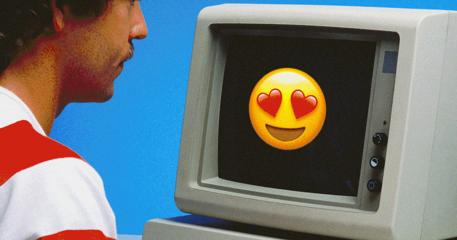

[Increasingly isolated people turn more to chatbots.](https://www.nbcnews.com/tech/ai-companions-friendship-rcna194735?ref=biztoc.com) - NBC News

___

[Sam Altman's 'proof of human' startup. Sounds crazy but I don't know how you avoid this. You probably need to regulate what it can be used for, for privacy and security reasons, the way you can't require SS number for everything and have PCI rules for credit cards.](https://www.wsj.com/tech/world-eye-orb-sam-altman-077e9f17)

___

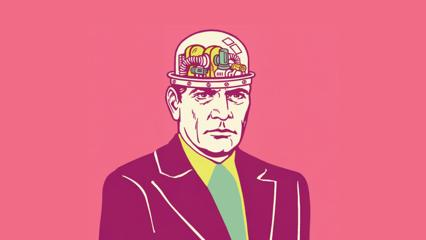

[What does “PhD-level” AI mean? OpenAI’s rumored \\$20,000 agent plan explained.](https://arstechnica.com/ai/2025/03/what-does-phd-level-ai-mean-openais-rumored-20000-agent-plan-explained/) - Ars Technica

___

[Wayfair to cut 340 tech jobs and move to AI](https://www.wsj.com/tech/ai/wayfair-to-cut-340-tech-jobs-as-part-of-ai-cloud-shift-75251c60)

___

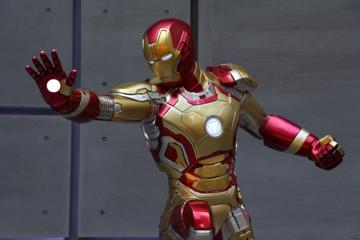

[AI cybersecurity suite (not suit) helps scan logs and resolve network security alerts](https://techcrunch.com/2025/03/06/crogl-armed-with-30m-takes-the-wraps-off-a-new-ai-iron-man-suit-for-security-analysts/) - TechCrunch

___

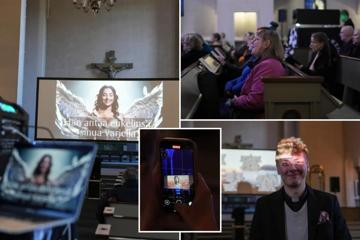

[AI-created hymns, sermons and prayers: touched by grace, or the devil's handiwork?](https://nypost.com/2025/03/08/tech/finland-st-pauls-lutheran-church-holds-ai-created-church-service-depicting-jesus-and-satan/) - New York Post

___

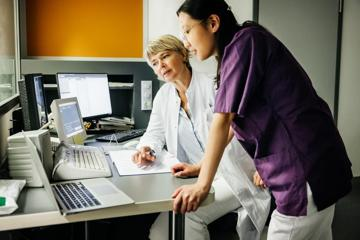

[AI must be designed help clinicians process information and enhance their judgment, but ofc it will tend to bias decisions in certain directions, some users might be lazy, insurance will want to go with AI to reduce costs, need to be very very careful.](https://www.forbes.com/councils/forbesbusinesscouncil/2025/03/07/clinicians-and-algorithms-misconceptions-by-healthcare-ai-companies/) - Forbes

___

[Interpretability is a huge problem in making high stakes decisions with AI.](https://www.theregister.com/2025/03/08/ai_kidney_transplant_moral_decisions/)

___

[Agents for medical case management](https://www.marktechpost.com/2025/03/07/this-ai-paper-from-google-unveils-an-ai-system-that-masters-disease-management-and-medication-reasoning-better-than-ever/)

___

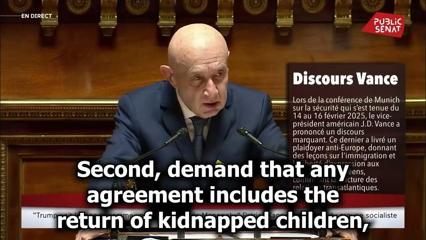

[Claude Malhuret, former president of Médecins Sans Frontières among others 

tough but fair … hard times reveal true character](https://www.youtube.com/watch?v=wmDVrV7QRrU) - YouTube

___

[Ex-DeepMind Researchers’ New Startup Aims for Superintelligence](https://www.bloomberg.com/news/articles/2025-03-07/ex-deepmind-researchers-new-startup-aims-for-superintelligence)

___

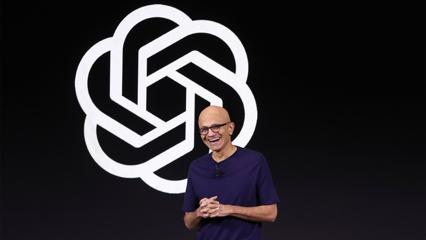

[Microsoft has  internal models competitive with OpenAI in testing, along with other 3rd-party models, looks to pivot from exclusive or OpenAI-first partnership.](https://techcrunch.com/2025/03/07/microsoft-reportedly-ramps-up-ai-efforts-to-compete-with-openai/) - TechCrunch

___

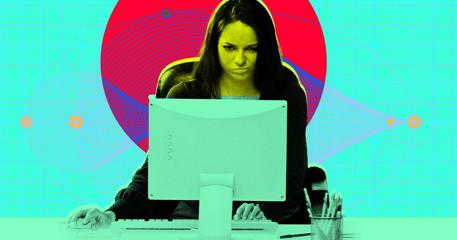

[Is Google AI mode just 'AI slop' mode?](https://futurism.com/the-byte/google-expanding-ai-search) - Futurism

___

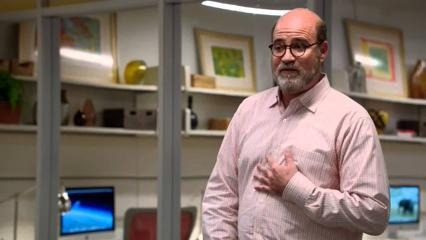

[Zune bad? or Apple Maps bad?](https://www.youtube.com/watch?v=tVq1wgIN62E) - YouTube

___

[Apple Delays Siri Upgrade Indefinitely as AI Concerns Escalate](https://www.bloomberg.com/news/articles/2025-03-07/apple-confirms-delay-of-ai-infused-personalized-siri-assistant)

___

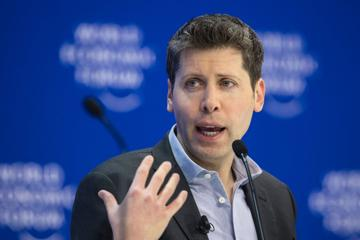

[Former OpenAI safety lead calls out the company for rewriting history to say previous safety practices were misguided and overkill 
techcrunch.com/2025/03/06/o...](https://techcrunch.com/2025/03/06/openais-ex-policy-lead-criticizes-the-company-for-rewriting-its-ai-safety-history/) - TechCrunch

___

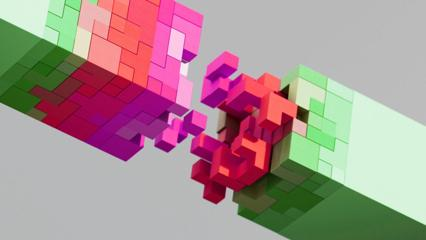

[Beat ARC-AGI with this one weird trick. 

these puzzles are relatively easy for humans to solve but hard for existing general reasoners, but it turns out image compression can hack the patterns. 

ofc the ultimate trick for AGI is creating un-hackable AGI benchmarks.](https://arstechnica.com/ai/2025/03/compression-conjures-apparent-intelligence-in-new-puzzle-solving-ai-approach/) - Ars Technica

___

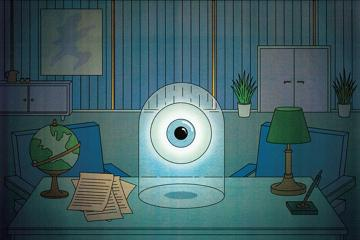

[The Labor Theory of AI | Ben Tarnoff](https://www.nybooks.com/articles/2025/03/27/the-labor-theory-of-ai-the-eye-of-the-master/) - The New York Review of Books

___

[Let AI plan your trip to NYC](https://www.nytimes.com/2025/03/07/travel/ai-travel-planning-nyc.html)

___

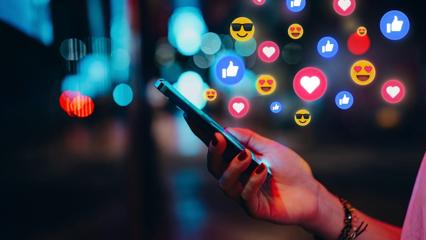

[SMBs can use AI as their social media manager](https://www.cnet.com/tech/services-and-software/no-social-media-manager-no-problem-heres-how-to-use-ai-in-its-place/) - CNET

___

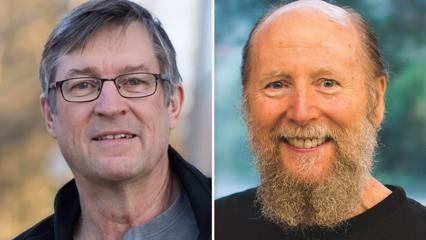

[Turing Award winners criticize race to deploy unsafe AI models](https://www.ft.com/content/d8f85d40-2c5b-4a2b-b113-87fa8e30f61b)

___

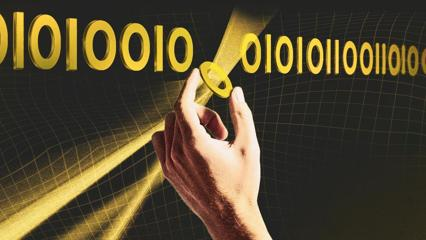

[Teaching AI is a growing side hustle for the young and educated](https://www.forbes.com/sites/richardnieva/2025/03/06/scale-ai-outlier-us/) - Forbes

___

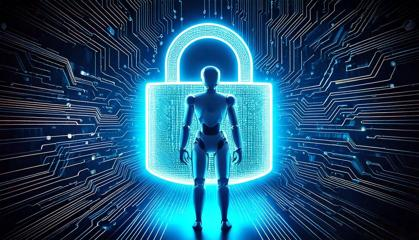

[AI seems more likely to flood the world with cheap slop and further immiserate and alienate artists, than launch a new creative renaissance.](https://www.techradar.com/computing/artificial-intelligence/were-locked-inside-a-creative-bubble-will-ai-burst-it-or-throw-away-the-key) - TechRadar

___

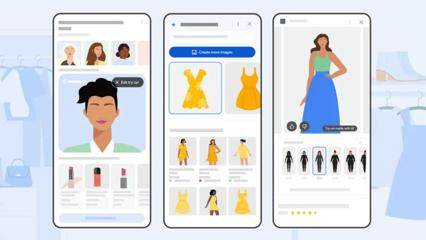

[Google Shopping adds AI features like virtual try-on](https://www.gadgets360.com/ai/news/google-shopping-ai-features-garment-search-virtual-try-on-rolling-out-7862262) - Gadgets 360

___

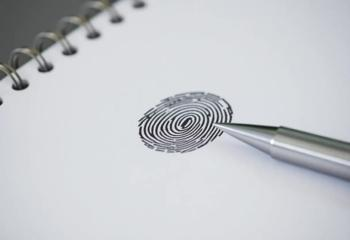

[AI to identify your writing by its stylistic quirks](https://hackernoon.com/your-writing-has-a-fingerprintand-this-cutting-edge-ai-model-can-spot-it)

___

[Palantir delivers AI-packed trucks to serve as situation rooms command posts in the field](https://www.bloomberg.com/news/articles/2025-03-07/palantir-is-delivering-mobile-ai-trucks-to-the-army)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [11]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [12]:
print(datetime.now())

2025-03-09 10:11:39.613019


In [13]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2025, 3, 9, 14, 10, 2, 212000)

In [14]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2025-03-08 04:11:39.628401


In [15]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=False):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


In [16]:
a

{'x': 1, 'y': 2}

In [17]:
b



NameError: name 'b' is not defined